<a href="https://colab.research.google.com/github/LeeSeungwon89/Machine-learning_Theory/blob/master/CHAPTER6%20%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98%20%EC%B2%B4%EC%9D%B8%EA%B3%BC%20%ED%8C%8C%EC%9D%B4%ED%94%84%EB%9D%BC%EC%9D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 들어가며

4장에서 살폈듯이 입력 데이터의 표현 형태에 민감한 머신러닝 알고리즘이 많습니다. 직접 데이터의 스케일을 조정하고 특성을 연결하는 것부터 시작해서 3장에서처럼 비지도 학습으로 특성을 만들기도 합니다. 따라서 대부분의 머신러닝 애플리케이션은 알고리즘 하나로 구성되지 않습니다. 여러 단계의 처리 과정과 머신러닝 모델이 연결되어 있습니다.

이번 장에서는 데이터 변환 과정과 머신러닝 모델을 쉽게 연결해주는 `Pipeline` 클래스를 설명합니다. 특히 `Pipeline`과 `GridSearchCV`를 함께 사용해서 각 처리 단계에서 필요한 매개변수 탐색을 동시에 수행하겠습니다.

모델 체인의 좋은 예로 3장에서 cancer 데이터셋을 `MinMaxScaler`로 전처리를 해서 커널 SVM의 성능을 향상시켰었습니다. cancer 데이터셋의 스케일을 조정하고 `SVC(C=100)` 모델을 사용해서 테스트 세트 정확도를 63% -> 97%만큼 개선했습니다.

다음은 데이터를 분할하고 최솟값, 최댓값을 찾아서 데이터의 스케일을 바꾸고 SVM을 훈련시키는 코드입니다.

In [12]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터를 적재하고 분할합니다.
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)
# 훈련 데이터의 최솟값, 최댓값을 계산합니다.
scaler = MinMaxScaler().fit(X_train)
# 훈련 데이터의 스케일을 조정합니다.
X_train_scaled = scaler.transform(X_train)
# 스케일이 조정된 훈련 데이터에 SVM을 학습시킵니다.
svm = SVC()
svm.fit(X_train_scaled, y_train)
# 테스트 데이터의 스케일을 조정하고 점수를 계산합니다.
X_test_scaled = scaler.transform(X_test)
print('테스트 점수: {:.2f}'.format(svm.score(X_test_scaled, y_test)))

테스트 점수: 0.97


# **6.1 데이터 전처리와 매개변수 선택**

5장에서처럼 `GridSearchCV`를 사용해서 더 좋은 SVC 매개변수를 찾고자 합니다. 단순한 방법을 코드로 구현합니다. 실제로 사용해서는 안 됩니다.

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train_scaled, y_train)
print('최상의 교차 검증 정확도: {:.2f}'.format(grid.best_score_))
print('테스트 점수: {:.2f}'.format(grid.score(X_test_scaled, y_test)))
print('최적 매개변수', grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적 매개변수 {'C': 1, 'gamma': 1}


스케일을 조정한 데이터를 사용해서 SVC의 매개변수에 대해 그리드 서치를 수행했습니다. 그러나 이 코드에는 교묘한 함정이 있습니다. 데이터의 최솟값과 최댓값을 계산할 때 학습을 위해 훈련 세트에 있는 모든 데이터를 사용했습니다. 그런 다음에 스케일이 조정된 훈련 데이터에서 교차 검증을 사용해서 그리드 서치를 수행했습니다. 교차 검증의 각 분할에서 원본 훈련 세트 데이터의 어떤 부분은 훈련 폴드가 되고 어떤 부분은 검증 폴드가 됩니다. 검증 폴드는 훈련 폴드로 학습된 모델이 새로운 데이터에 적용될 때의 성능을 측정하는 데 사용합니다. 그러나 데이터 스케일을 조정할 때 검증 폴드에 들어 있는 정보까지 전부 사용했습니다. 다시 말하면 교차 검증의 반복마다 선택된 검증 폴드는 전체 훈련 세트의 일부이고, 우리는 데이터의 스케일을 조정하고자 전체 훈련 세트를 이용했습니다. 하지만 이는 새로운 데이터가 모델에 나타날 때와 완전히 다릅니다. 새로운 데이터가 관측되면 이 데이터는 훈련 데이터의 스케일 조정에 사용되지 않은 것이므로 최솟값과 최댓값이 훈련 데이터와 다를 수 있습니다.

교차 검증이 수행되는 동안 데이터 처리와 최종 평가가 어떻게 다른지 설명하는 그림을 출력합니다.

In [14]:
pip install mglearn

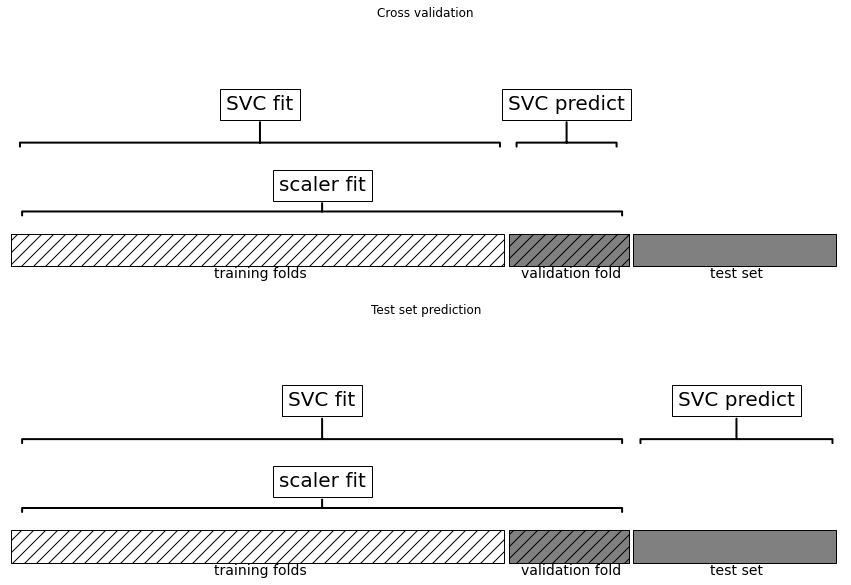

In [15]:
import mglearn

mglearn.plots.plot_improper_processing()

교차 검증 반복 밖에서 전처리가 될 때의 데이터 사용 형태를 나타내는 그림입니다. 상단 그림은 매개변수 선택을 할 때 교차 검증에서 `scaler.fit`과 `SVC.predict`가 모두 검증 폴드를 사용합니다. 하지만 하단 그림은 모델 성능을 평가할 때 `scaler.fit`이 테스트 세트에 적용되지 않습니다.

교차 검증의 분할 방식은 모델이 새 데이터를 만났을 때를 올바로 반영하지 못합니다. 검증 폴드 데이터의 정보가 모델 구축 과정에 이미 알려졌으므로 교차 검증에서 최적의 매개변수를 찾지 못하고 낙관적인 결과를 도출합니다.

이 문제를 해결하려면 모든 전처리 과정보다 교차 검증의 분할이 먼저 이뤄져야 합니다. 데이터셋의 정보를 이용하는 모든 처리 과정은 데이터셋의 훈련 부분에만 적용되어야 하므로 교차 검증 반복 안에 있어야 합니다.

`cross_val_score` 함수와 `GridSearchCV` 함수를 `Pipeline`을 사용하여 위 설명에서 제시한 방법을 구현할 수 있습니다. `Pipeline`은 여러 처리 단계를 하나의 추정기 형태로 묶는 클래스입니다(`BaseEstimator` 클래스를 상속합니다). 아울러 `fit`, `predict`, `score` 메서드를 제공하고, 다른 모델들과 유사하게 작동합니다. `Pipeline`을 사용하는 가장 일반적인 경우는 분류기 같은 지도 학습 모델과 데이터 스케일 조정 같은 전처리 단계를 연결하는 것입니다.

# **6.2 파이프라인 구축하기**

`Pipeline`을 사용해서 `MinMaxScaler`로 데이터 스케일을 조정하고 SVM 모델을 훈련하는 워크플로(workflow)를 표현하는 방식을 알아봅니다.

먼저 각 단계를 리스트로 전달해서 파이프라인 객체를 만듭니다. 각 단계는 추정기의 객체와 임의의 이름(밑줄 문자(_)는 사용 불가능)으로 구성된 튜플(tuple)입니다. 여기서 튜플은 리스트와는 달리 원소를 추가하거나 삭제, 변경할 수 없고 소괄호 형태로 구성됩니다.

In [16]:
from sklearn.pipeline import Pipeline

# 튜플 형태로 구성하여 객체로 넘깁니다.
pipe = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC())])

두 단계를 생성했습니다. 첫 번째 단계와 두 번째 단계를 차례대로 지정한 것입니다. 

다른 예측 모델처럼 파이프라인으로 `fit` 메서드를 호출합니다.

In [17]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svm',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

`pipe.fit`은 첫 번째 단계인 'scaler'의 `fit` 메서드를 호출해서 훈련 데이터를 변환하고, 마지막으로 변환된 데이터에 SVM 모델을 훈련합니다.

테스트 세트로 평가하려면 `pipe.score`를 호출합니다.

In [18]:
print('테스트 점수: {:.2f}'.format(pipe.score(X_test, y_test)))

테스트 점수: 0.97


파이프라인에서 `score` 메서드를 호출하면 먼저 'scaler'를 사용해서 테스트 데이터를 변환하고, 변환된 데이터에 SVM 모델의 `score` 메서드를 호출합니다. 결괏값은 이 파트의 처음 부분에 직접 변환한 코드의 결괏값과 같습니다.

파이프라인을 사용하면 전처리하고 분류하는 과정을 나타내는 코드의 길이가 줄어듭니다. 무엇보다도 더 큰 장점은 `cross_val_score`와 `GridSearchCV`에 파이프라인을 하나의 추정기처럼 사용할 수 있는 것입니다.

# **6.3 그리드 서치에 파이프라인 적용하기**

그리드 서치에 파이프라인을 사용하는 방식도 다른 추정기를 사용하는 방식과 동일합니다. 탐색할 매개변수 그리드를 정의하고, 이 매개변수 그리드와 파이프라인으로 `GridSearchCV`의 객체를 생성합니다. 조금 달라지는 부분이 있다면 각 매개변수가 파이프라인의 어떤 단계에 속한 것인지 지정해야 합니다. `C` 매개변수와 `gamma` 매개변수는 두 번째 단계인 SVC의 매개변수입니다. 앞에서 이 단계의 이름을 'svm'으로 지정했습니다. 파이프라인용 매개변수 그리드는 단계 이름과 매개변수 이름을 밑줄 2개로 연결해서 생성합니다. 따라서 SVC의 매개변수를 그리드 서치로 탐색하려면 매개변수 그리드 딕셔너리의 키를 'svm__C'와 'svm__gamma'로 지정해야 합니다.

In [19]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

이 매개변수 그리드로 `GridSearchCV`를 그대로 사용할 수 있습니다.

In [22]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print('최상의 교차 검증 정확도: {:.2f}'.format(grid.best_score_))
print('테스트 세트 점수: {:.2f}'.format(grid.score(X_test, y_test)))
print('최적 매개변수', grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 세트 점수: 0.97
최적 매개변수 {'svm__C': 1, 'svm__gamma': 1}


# **6.4 파이프라인 인터페이스**

## **6.4.1 make_pipeline을 사용한 파이프라인 생성**

## **6.4.2 단계 속성에 접근하기**

## **6.4.3 그리드 서치 안의 파이프라인 속성에 접근하기**

# **6.5 전처리와 모델의 매개변수를 위한 그리드 서치**

# **6.6 모델 선택을 위한 그리드 서치**

## **6.6.1 중복 계산 피하기**

# **6.7 요약 및 정리**